In [1]:
#Packages

In [42]:
import numpy as np
import pandas as pd #to read dataset
#for graphics of best model
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
from tensorflow import keras

# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# evaluation metrics
from sklearn.metrics import mean_squared_error #mean_squared_error(y_true, y_pred)
from sklearn.metrics import r2_score #r2_score(y_true, y_pred)

#For the decision tree graphic
#Need: pip install pydot and pip install graphviz and sudo pip install pydot and pip install graphviz, update nope need to install homebrew then: brew install graphviz
import pydot
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
#Data & Splitting

In [4]:
#Dataset 
df = pd.read_csv('v2refined74.csv')

#first, separate the full df into 2 by rows assigning some % of the rows to training and some to testing, for example by

train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)

#in this way you slice your data horizontally.

#then, identify which columns should be in your training data (X) and which in your training labels(Y). Then explicitly select them:

X_train = train[['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS']].values.astype(float)
y_train = train['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED'].values.astype(float) 

#Note that columns should be the same for training and testing, including the order:

X_test = test[['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS']].values.astype(float)
y_test = test['BIODEGRADATION_HALF_LIFE_DAYS_DAYS_OPERA_PRED'].values.astype(float)

In [5]:
#Function to evaluate RMSE

In [6]:
def model_evaluate(y_train, y_test, y_pred, y_pred_train):
    metrics = {}
    #RMSE Test
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    #RMSE Train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    #MSE Test
    mse_test = mean_squared_error(y_test, y_pred)
    #MSE Train
    mse_train = mean_squared_error(y_train, y_pred_train)
    #R2 Test
    r2_test = r2_score(y_test, y_pred)
    #R2 Train
    r2_train = r2_score(y_train, y_pred_train)

    metrics = {
              'RMSE Test': rmse_test,
              'RMSE Train': rmse_train,
              'MSE Test': mse_test,
              'MSE Train': mse_train,
              'R2 Test': r2_test,
              'R2 Train': r2_train}

    return metrics 

In [7]:
#Iteration 1: Using the model with default hyperparameters

In [24]:
#1. import the class/model
#from sklearn.ensemble import RandomForestRegressor
#2. Instantiate the estimator
RFReg = RandomForestRegressor(random_state = 1, n_jobs = -1) 
#3. Fit the model with data aka model training
RFReg.fit(X_train, y_train)

#4. Predict the response for a new observation
y_pred = RFReg.predict(X_test)


y_pred_train = RFReg.predict(X_train)

In [25]:
model_evaluate(y_train, y_test, y_pred, y_pred_train)

{'RMSE Test': 0.5504302563097744,
 'RMSE Train': 0.42766798114590243,
 'MSE Test': 0.30297346706124395,
 'MSE Train': 0.18289990209741197,
 'R2 Test': 0.12004620007982225,
 'R2 Train': 0.7860096619414028}

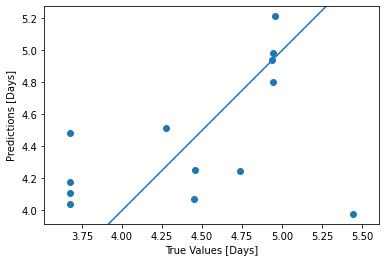

In [29]:
test_predictions = RFReg.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values [Days]')
plt.ylabel('Predictions [Days]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

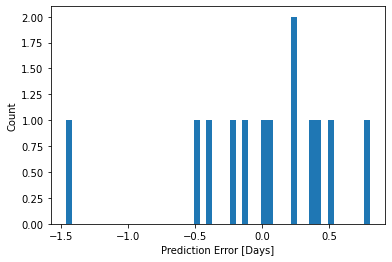

In [30]:
# histogram
error = y_pred - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [Days]")
_ = plt.ylabel("Count")

In [31]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [36]:
dfxTrain=pd.DataFrame(X_train, columns=['Number of Carbons','Number of Fluorines','Contains N','Contains O','Contains S','MONOISOTOPIC_MASS'])


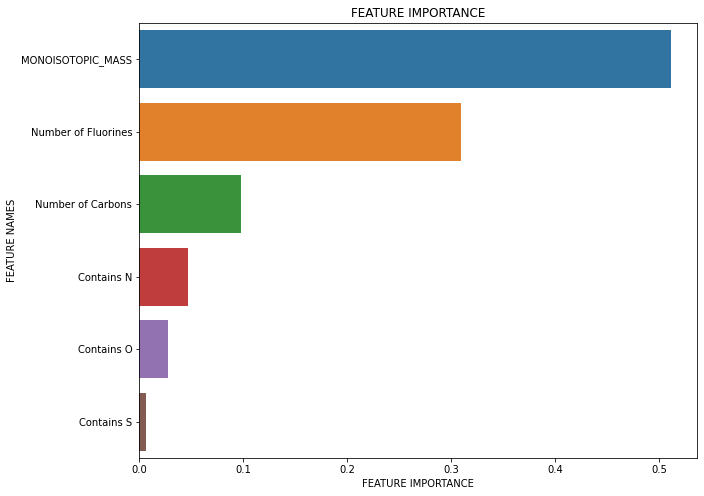

In [40]:
plot_feature_importance(RFReg.feature_importances_, dfxTrain.columns)

In [41]:
#Extract List of features from data frame.
feature_list = list(dfxTrain.columns)
# Get numerical feature importances
importances = list(RFReg.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: MONOISOTOPIC_MASS    Importance: 0.51
Variable: Number of Fluorines  Importance: 0.31
Variable: Number of Carbons    Importance: 0.1
Variable: Contains N           Importance: 0.05
Variable: Contains O           Importance: 0.03
Variable: Contains S           Importance: 0.01


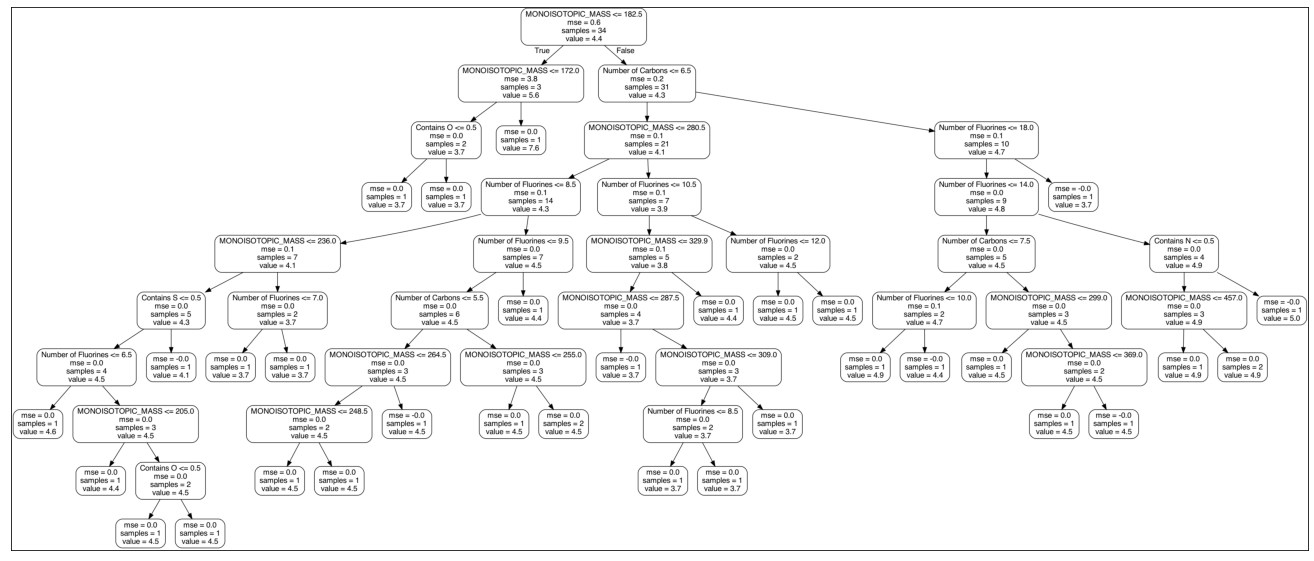

In [43]:
def plot_decisiontree(img_name):
    tree_image = plt.imread(img_name)
    plt.figure(figsize=(100,10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(tree_image)
    plt.show()
rf_tree = RFReg.estimators_[5]
export_graphviz(rf_tree, out_file = 'rf.dot', feature_names = feature_list, rounded = True, precision = 1)
# Write graph to a png file
(graph_rf, ) = pydot.graph_from_dot_file('rf.dot')
graph_rf.write_png('rf.png')
plot_decisiontree('rf.png')

In [10]:
#Iteration 2: I used RandomizedSearchCV to get optimum values of hyper-parameters

In [11]:
#from sklearn.ensemble import RandomForestRegressor
RFReg = RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs = -1) 

param_grid = { 
    'max_features' : ["auto", "sqrt", "log2"],
    'min_samples_split' : np.linspace(0.1, 1.0, 10),
     'max_depth' : [x for x in range(1,20)]
}
from sklearn.model_selection import RandomizedSearchCV
CV_rfc = RandomizedSearchCV(estimator=RFReg, param_distributions =param_grid, n_jobs = -1, cv= 10, n_iter = 50)
CV_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [12]:
print(CV_rfc.best_params_)
CV_rfc.best_score_

{'min_samples_split': 1.0, 'max_features': 'sqrt', 'max_depth': 4}


-0.7716785746316106

In [22]:
#1. import the class/model
from sklearn.ensemble import RandomForestRegressor
#2. Instantiate the estimator
RFReg = RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs = -1, min_samples_split = 1.0, max_features = 'sqrt', max_depth = 4) 
#3. Fit the model with data aka model training
RFReg.fit(X_train, y_train)

#4. Predict the response for a new observation
y_pred = RFReg.predict(X_test)


y_pred_train = RFReg.predict(X_train)


In [23]:
model_evaluate(y_train, y_test, y_pred, y_pred_train)

{'RMSE Test': 0.6044021972004106,
 'RMSE Train': 0.9245722410725633,
 'MSE Test': 0.3653020159806839,
 'MSE Train': 0.854833828961942,
 'R2 Test': -0.06098035646047428,
 'R2 Train': -0.0001436739209681459}

In [15]:
#Iteration 3: I use GridSearchCV to get optimum values of hyper-parameters

In [16]:
#from sklearn.ensemble import RandomForestRegressor
RFReg = RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs = -1) 

param_grid = { 
    'max_features' : ["auto", "sqrt", "log2"],
    'min_samples_split' : np.linspace(0.1, 1.0, 10),
     'max_depth' : [x for x in range(1,20)]

}

from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=RFReg, param_grid=param_grid, cv= 10, n_jobs = -1)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])})

In [17]:
print(CV_rfc.best_params_)
CV_rfc.best_score_

{'max_depth': 4, 'max_features': 'auto', 'min_samples_split': 0.8}


-0.7716785746316102

In [20]:
#1. import the class/model
from sklearn.ensemble import RandomForestRegressor
#2. Instantiate the estimator
RFReg = RandomForestRegressor(n_estimators = 100, random_state = 1, n_jobs = -1, min_samples_split = 0.8, max_features = 'auto', max_depth = 4) 
#3. Fit the model with data aka model training
RFReg.fit(X_train, y_train)

#4. Predict the response for a new observation
y_pred = RFReg.predict(X_test)


y_pred_train = RFReg.predict(X_train)

In [21]:
model_evaluate(y_train, y_test, y_pred, y_pred_train)

{'RMSE Test': 0.6044021972004106,
 'RMSE Train': 0.9245722410725633,
 'MSE Test': 0.3653020159806839,
 'MSE Train': 0.854833828961942,
 'R2 Test': -0.06098035646047428,
 'R2 Train': -0.0001436739209681459}